# Purpose
- examine the interday gap (if any) and intraday change for top gainers (following a day of a lot of gain)
- examine whether a positive or negative interday gap correlates with the following intraday change

In [ ]:
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.2f' % x)
from datetime import datetime, timedelta
import yahoo_fin.stock_info as si
import sys
sys.path.append(<PATH>)
%cd <PATH>
import tda_data
import time
import seaborn as sns
import matplotlib.pyplot as plt
print('\nPackages imported', datetime.now(), '\n')

In [14]:
top_gainers = si.get_day_gainers()
top_gainers['PV'] = top_gainers['Price (Intraday)'] * top_gainers['Volume']
top_gainers = top_gainers[top_gainers['PV']>=100000000]
top_gainers

,Symbol,Name,Price (Intraday),Change,% Change,Volume,Avg Vol (3 month),Market Cap,PE Ratio (TTM),PV
3,CHGG,"Chegg, Inc.",25.75,4.64,21.98,10311000.00,1536000.00,3255000000.00,85.83,265508250.00
6,SMCI,"Super Micro Computer, Inc.",80.84,8.98,12.50,3636000.00,636753.00,4232000000.00,14.72,293934240.00
7,LI,Li Auto Inc.,16.32,1.76,12.09,38540000.00,10431000.00,15924000000.00,1632.00,628972800.00
9,HZNP,Horizon Therapeutics Public Limited Company,70.33,7.15,11.32,7381000.00,3149000.00,16203000000.00,22.69,519105730.00
11,UTHR,United Therapeutics Corporation,253.65,25.26,11.06,1702000.00,356043.00,11545000000.00,19.38,431712300.00
13,SCI,Service Corporation International,67.49,6.34,10.37,2859000.00,1123000.00,10641000000.00,14.55,192953910.00
23,YUMC,"Yum China Holdings, Inc.",46.32,3.26,7.57,4299000.00,2217000.00,19396000000.00,26.32,199129680.00
24,INSP,"Inspire Medical Systems, Inc.",206.79,14.53,7.56,895979.00,298268.00,5953000000.00,NaN,185279497.41
25,NYT,The New York Times Company,31.33,2.19,7.52,3370000.00,1464000.00,5209000000.00,27.48,105582100.00
27,NVO,Novo Nordisk A/S,113.30,6.87,6.45,2143000.00,1707000.00,257415000000.00,38.28,242801900.00


In [18]:
tickers = top_gainers.Symbol.to_list()

dfs = {ticker: None for ticker in tickers}
assert len(tickers) == len(set(tickers))
print(len(tickers), 'total tickers')

for ticker in tickers:
    
    # print(ticker)
    
    dfs[ticker] = tda_data.daily_adj(ticker).copy(deep=True)
    for col in ['open','high','low','close']:
        dfs[ticker][col] = dfs[ticker][col].astype(float)
    
    # predictors
    dfs[ticker]['interday'] = dfs[ticker]['open'] / dfs[ticker]['close'].shift(1) - 1
    dfs[ticker]['intraday'] = dfs[ticker]['close'] / dfs[ticker]['open'] - 1
    dfs[ticker]['change'] = dfs[ticker]['close'] / dfs[ticker]['close'].shift(1) - 1
    dfs[ticker]['drawup'] = dfs[ticker]['high'] / dfs[ticker]['open'] - 1
    
    # response
    dfs[ticker]['intraday_t1'] = dfs[ticker]['intraday'].shift(-1)
    dfs[ticker]['interday_t1'] = dfs[ticker]['interday'].shift(-1)
    dfs[ticker]['change_t1'] = dfs[ticker]['change'].shift(-1)
    dfs[ticker]['drawup_t1'] = dfs[ticker]['drawup'].shift(-1)

22 total tickers


In [31]:
def run_func(trigger):
    
    results_df = pd.DataFrame()

    for ticker in tickers:

        # for loop

        df = dfs[ticker].copy(deep=True)
        df.reset_index(inplace=True)
        df.rename(columns={'index':'date'}, inplace=True)

        for index, row in df.iterrows():

            if index == df.index.max():
                continue

            if df.at[index, 'change'] >= trigger:

                results_df.at[index, 'ticker'] = ticker

                for col in ['date', 'intraday', 'change', 'intraday_t1', 'interday_t1', 'change_t1', 'drawup_t1']:
                    results_df.at[index, col] = df.at[index, col]

    ##############################################################################################################

    # cleanup
    results_df_2 = results_df[(results_df['intraday_t1']<=1) & (results_df['interday_t1']<=1) & (results_df['change_t1']<=1)]
    results_df_2 = results_df_2[(results_df_2['intraday_t1']>=-1) & (results_df_2['interday_t1']>=-1) & (results_df_2['change_t1']>=-1)]
    results_df_2 = results_df_2.sort_values('date')
    
    print('original')
    display(results_df_2['intraday_t1'].describe())
    print('')

    print('\nconditioned on negative interday')
    display(results_df_2[results_df_2['interday_t1']<0]['intraday_t1'].describe())
    original_len = len(results_df_2[(results_df_2['interday_t1']<0)])
    print(len(results_df_2[(results_df_2['interday_t1']<0) & (results_df_2['intraday_t1']>0)]) / original_len, 'win')
    print(len(results_df_2[(results_df_2['interday_t1']<0) & (results_df_2['intraday_t1']<0)]) / original_len, 'loss')
    print(len(results_df_2[(results_df_2['interday_t1']<0) & (results_df_2['intraday_t1']==0)]) / original_len, 'zero')
    print('')

    print('\nconditioned on positive interday')
    display(results_df_2[results_df_2['interday_t1']>0]['intraday_t1'].describe())
    original_len = len(results_df_2[(results_df_2['interday_t1']>0)])
    print(len(results_df_2[(results_df_2['interday_t1']>0) & (results_df_2['intraday_t1']<0)]) / original_len, 'win')
    print(len(results_df_2[(results_df_2['interday_t1']>0) & (results_df_2['intraday_t1']>0)]) / original_len, 'loss')
    print(len(results_df_2[(results_df_2['interday_t1']>0) & (results_df_2['intraday_t1']==0)]) / original_len, 'zero')
    print('')

    ##############################################################################################################

    sns.histplot(results_df_2['intraday_t1'])
    plt.title('unfiltered intraday_t1')
    plt.show()

    sns.histplot(results_df_2[results_df_2['interday_t1']<0]['intraday_t1'])
    plt.title('intraday_t1 conditioned on interday_t1 < 0')
    plt.show()

    sns.histplot(results_df_2[results_df_2['interday_t1']>0]['intraday_t1'])
    plt.title('intraday_t1 conditioned on interday_t1 > 0')
    plt.show()

    ##############################################################################################################

    longs = results_df_2[results_df_2['interday_t1']<0].copy(deep=True).reset_index(drop=True)
    shorts = results_df_2[results_df_2['interday_t1']>0].copy(deep=True).reset_index(drop=True)

    plt.plot(longs['date'], longs['intraday_t1'].cumsum())
    plt.title('longs')
    plt.show()

    plt.plot(shorts['date'], shorts['intraday_t1'].cumsum())
    plt.title('shorts')
    plt.show()

original


count   2646.00
mean       0.00
std        0.04
min       -0.20
25%       -0.02
50%       -0.00
75%        0.02
max        0.41
Name: intraday_t1, dtype: float64



conditioned on negative interday


count   1177.00
mean       0.00
std        0.04
min       -0.13
25%       -0.02
50%        0.00
75%        0.02
max        0.26
Name: intraday_t1, dtype: float64

0.5038232795242141 win
0.47578589634664403 loss
0.020390824129141887 zero


conditioned on positive interday


count   1282.00
mean      -0.00
std        0.04
min       -0.20
25%       -0.02
50%       -0.00
75%        0.02
max        0.41
Name: intraday_t1, dtype: float64

0.5335413416536662 win
0.44305772230889234 loss
0.0234009360374415 zero



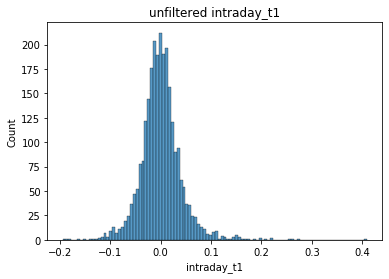

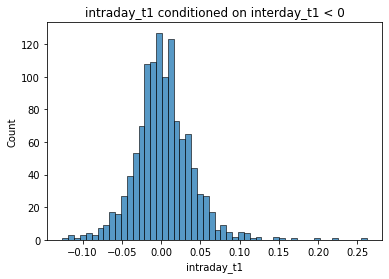

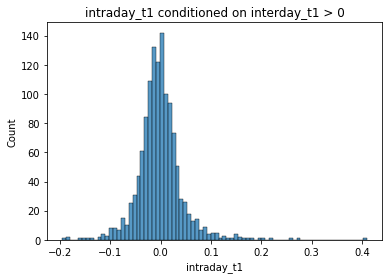

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for mult

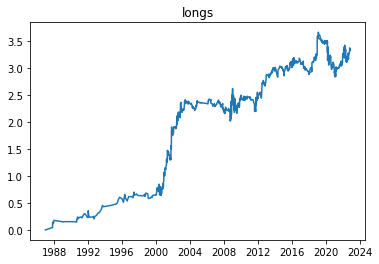

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


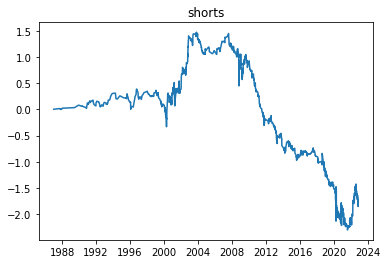

In [32]:
run_func(.05)

original


count   578.00
mean     -0.00
std       0.06
min      -0.20
25%      -0.03
50%      -0.00
75%       0.03
max       0.41
Name: intraday_t1, dtype: float64



conditioned on negative interday


count   266.00
mean      0.00
std       0.05
min      -0.17
25%      -0.02
50%      -0.00
75%       0.03
max       0.12
Name: intraday_t1, dtype: float64

0.462406015037594 win
0.5225563909774437 loss
0.015037593984962405 zero


conditioned on positive interday


count   268.00
mean     -0.00
std       0.07
min      -0.20
25%      -0.04
50%      -0.01
75%       0.02
max       0.41
Name: intraday_t1, dtype: float64

0.5485074626865671 win
0.4291044776119403 loss
0.022388059701492536 zero



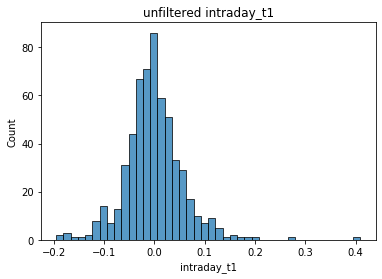

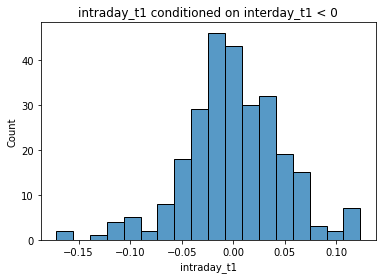

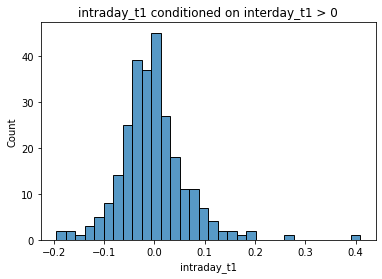

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for mult

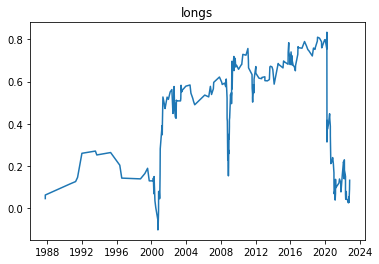

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


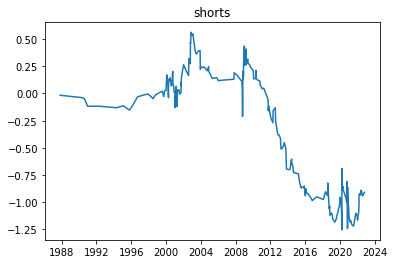

In [33]:
run_func(.1)

original


count   84.00
mean    -0.00
std      0.06
min     -0.20
25%     -0.03
50%     -0.00
75%      0.03
max      0.18
Name: intraday_t1, dtype: float64



conditioned on negative interday


count   47.00
mean    -0.00
std      0.05
min     -0.13
25%     -0.03
50%     -0.00
75%      0.03
max      0.12
Name: intraday_t1, dtype: float64

0.44680851063829785 win
0.5531914893617021 loss
0.0 zero


conditioned on positive interday


count   30.00
mean    -0.01
std      0.08
min     -0.20
25%     -0.04
50%      0.00
75%      0.03
max      0.18
Name: intraday_t1, dtype: float64

0.5 win
0.5 loss
0.0 zero



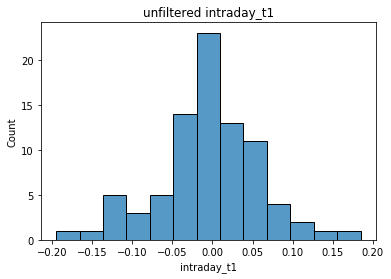

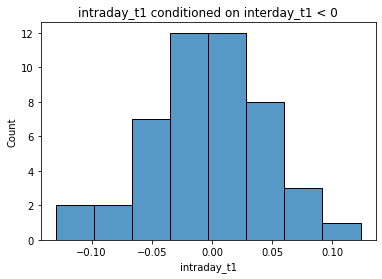

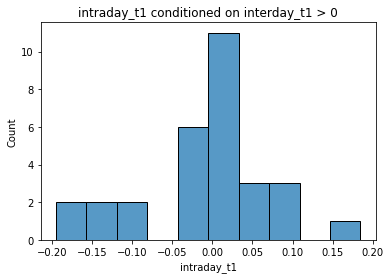

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for mult

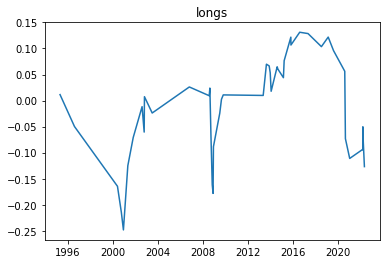

/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x[:, None]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/Users/michaelkwok/opt/anaconda3/lib/python3.7/site-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


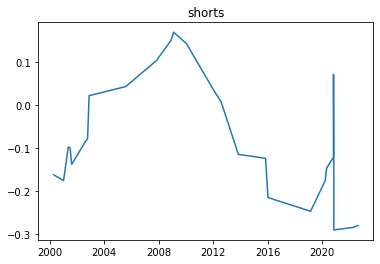

In [34]:
run_func(.2)